# Import Libraries

In [1]:
#!pip install imbalanced-learn

# import necessary libraries
import pandas as pd # manipulasi dataframe
import numpy as np # manipulasi array
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization

# import data modelling libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# PCA sensitif dengan angka -> Z score normalization = dibutuhkan oleh PCA utk memproses dataset menjadi PC
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential # define sequential models
from keras.layers import Dense # hidden layer

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# load the datasets
train_data = pd.read_csv("new_train.csv")
df = pd.DataFrame(train_data)

# check shape of dataset
print("shape of the data:", train_data.shape)
df.head()

shape of the data: (32950, 16)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


## check missing data
One of the main steps in data preprocessing is handling missing data. Missing data means absence of observations in columns that can be caused while procuring the data, lack of information, incomplete results etc. Feeding missing data to your machine learning model could lead to wrong prediction or classification. Hence it is necessary to identify missing values and treat them.

In [3]:
# check data types of all columns
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

## check class imbalance

In [5]:
# target class count
df["y"].value_counts()

no     29238
yes     3712
Name: y, dtype: int64

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'target variable')

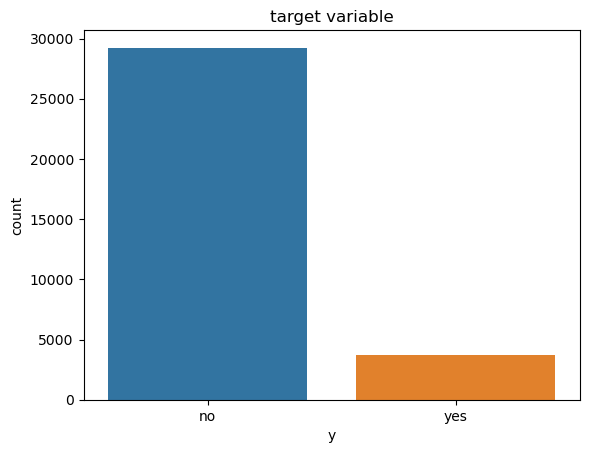

In [6]:
# target class figure 
plt.figure(facecolor = "white")
sns.countplot(df["y"])
plt.title("target variable")

In [7]:
# percentage of class present in target variable(y) 
print("percentage of NO and YES\n",df["y"].value_counts()/len(df)*100)

percentage of NO and YES
 no     88.734446
yes    11.265554
Name: y, dtype: float64


The class distribution in the target variable is ~89:11 indicating an imbalance dataset

# Exploratory Data Analysis

## univariate analysis of categorical variables

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


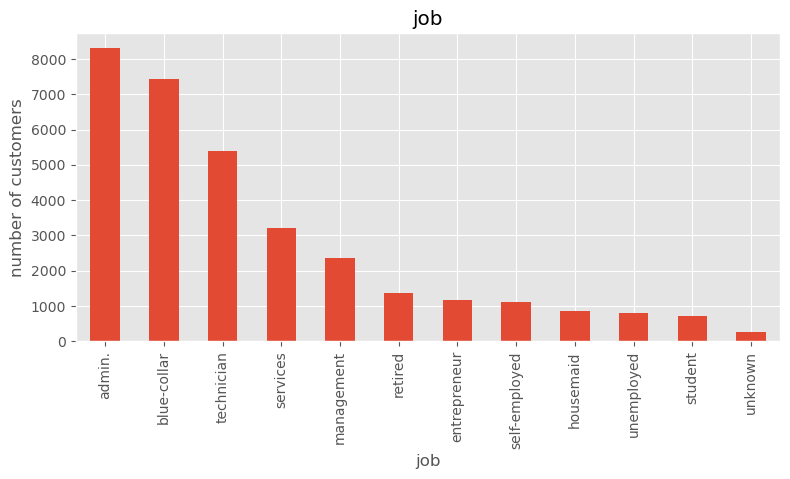

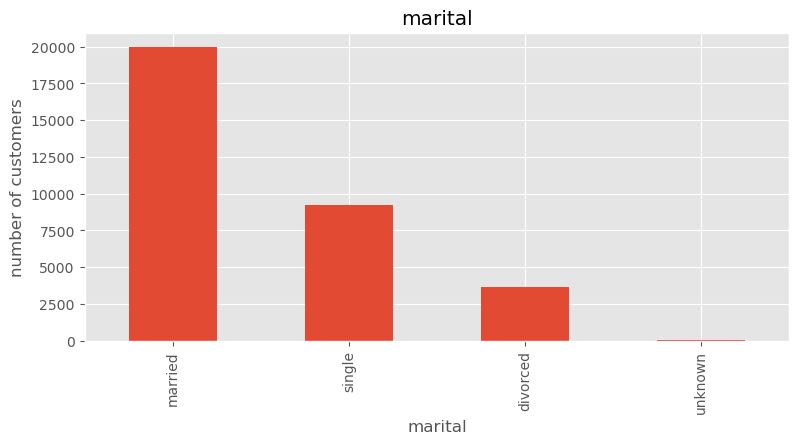

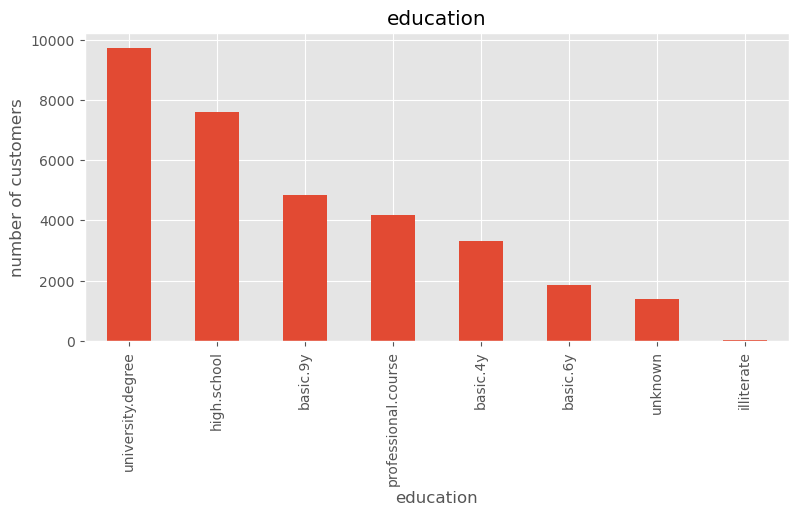

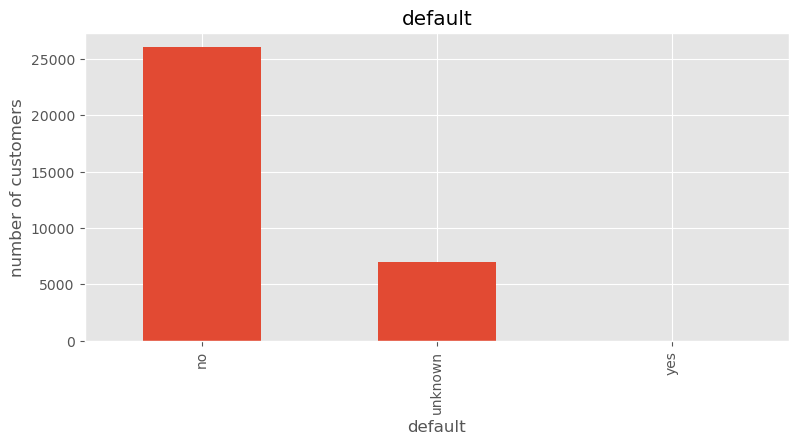

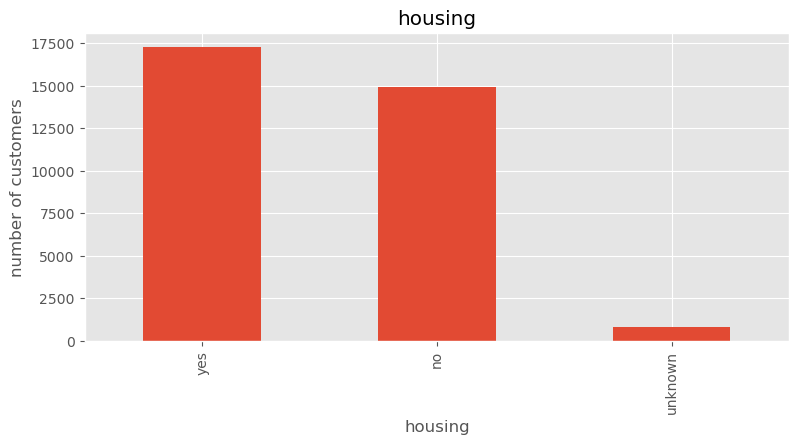

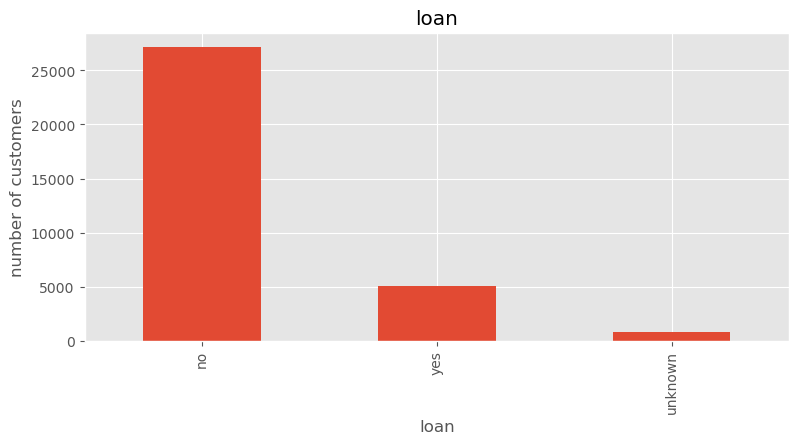

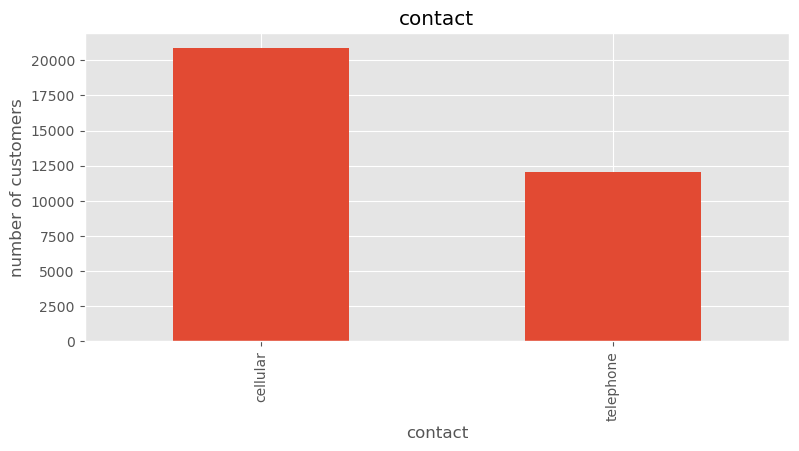

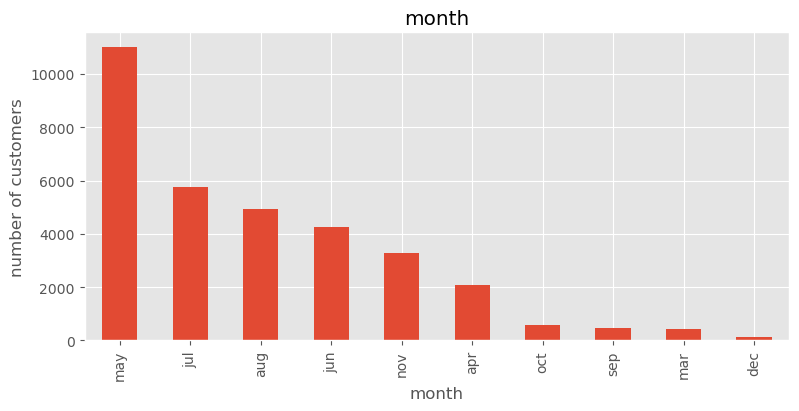

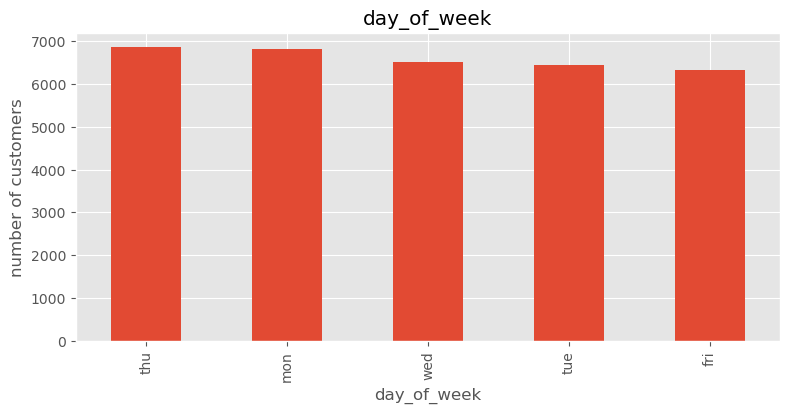

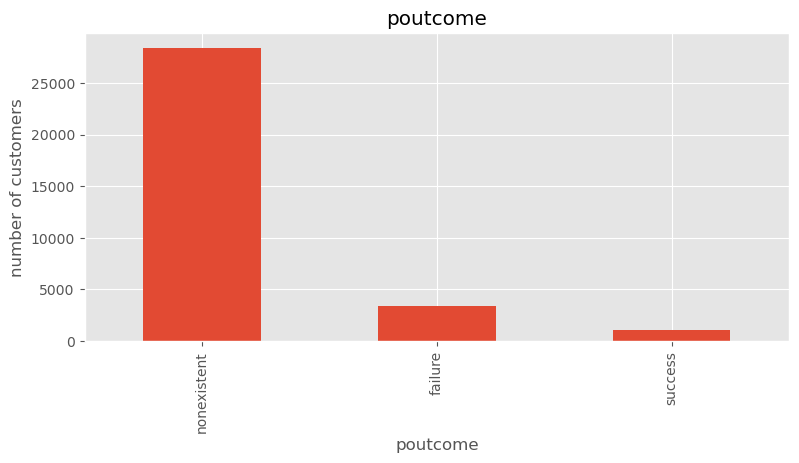

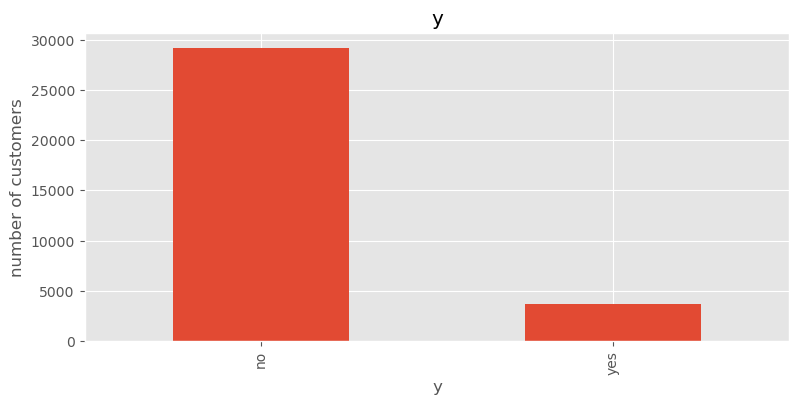

In [8]:
# indentifying the categorical variables
cat_var= df.select_dtypes(include= ["object"]).columns
print(cat_var)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    df[column].value_counts().plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("number of customers")
    plt.title(column)

## Observations :
The top three professions that our customers belong to are - administration, blue-collar jobs and technicians.
A huge number of the customers are married.
Majority of the customers do not have a credit in default
Many of our past customers have applied for a housing loan but very few have applied for personal loans.
Cell-phones seem to be the most favoured method of reaching out to customers.
Many customers have been contacted in the month of May.
The plot for the target variable shows heavy imbalance in the target variable.

The missing values in some columns have been represented as unknown. unknown represents missing data.

In [9]:
# replacing "unknown" with the mode
for column in cat_var:
    mode= df[column].mode()[0]
    df[column]= df[column].replace("unknown", mode)

In [10]:
# indentifying the numerical variables
num_var= df.select_dtypes(include=np.number)
num_var.head()

,age,duration,campaign,pdays,previous
0,49,227,4,999,0
1,37,202,2,999,1
2,78,1148,1,999,0
3,36,120,2,999,0
4,59,368,2,999,0


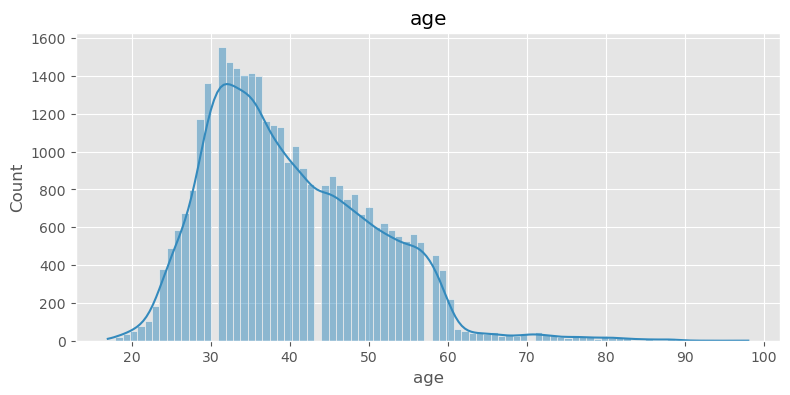

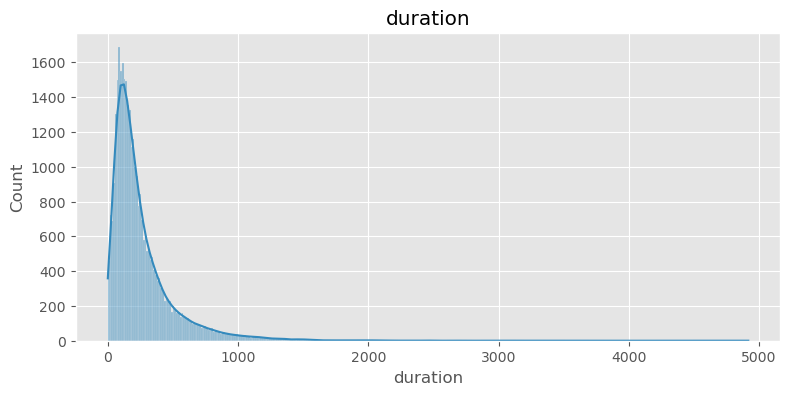

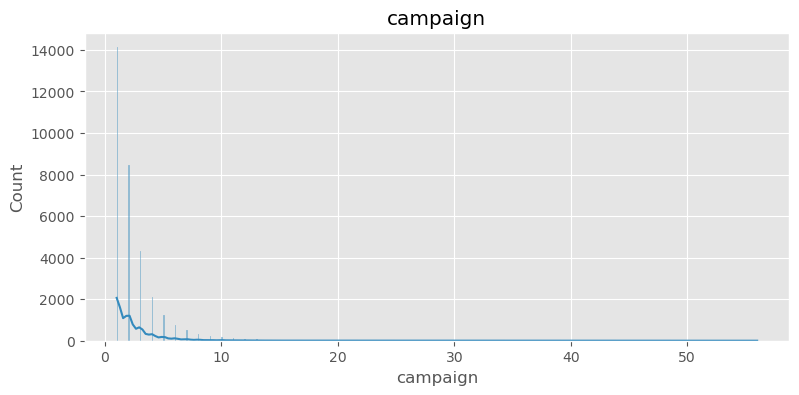

In [11]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "duration", "campaign"]:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.histplot(df[column], kde=True)
    plt.title(column)

## Observation :
As we can see from the histogram, the features age, duration and campaign are heavily skewed and this is due to the presence of outliers as seen in the boxplot for these features.
Looking at the plot for pdays, we can infer that majority of the customers were being contacted for the first time because as per the feature description for pdays the value 999 indicates that the customer had not been contacted previously.

Since pdays and previous consist majorly only of a single value, their variance is quite less and hence we can drop them since technically will be of no help in prediction.

In [12]:
# drop pdays and previous because low variance
df.drop(columns=["pdays", "previous"], axis=1, inplace=True)

# check shape of dataset df after drop 2 columns
print("shape of the data:", df.shape)
df.head()

shape of the data: (32950, 14)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,blue-collar,married,basic.9y,no,no,no,cellular,nov,wed,227,4,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,nonexistent,no


## Bivariate Analysis of Categorical Columns

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-p

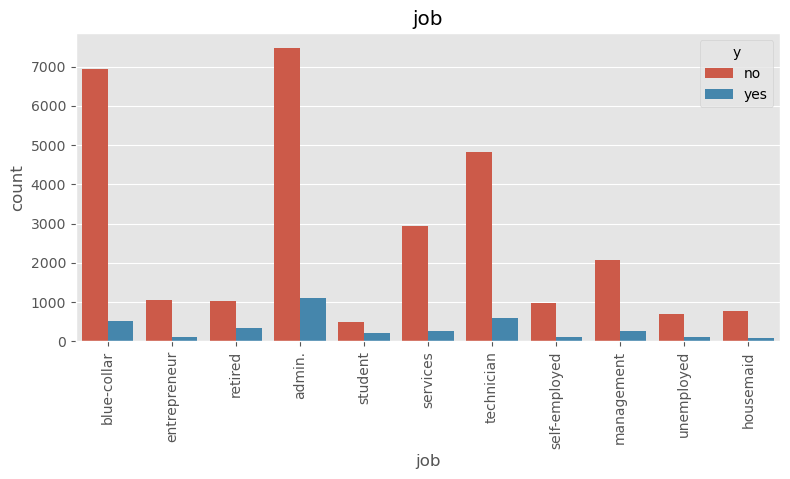

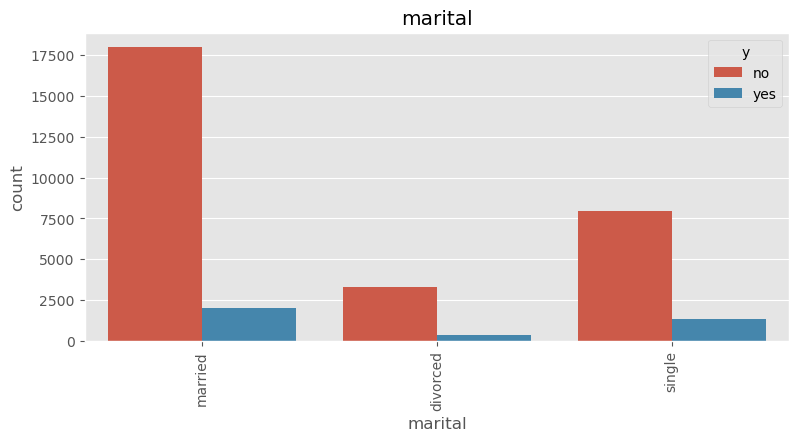

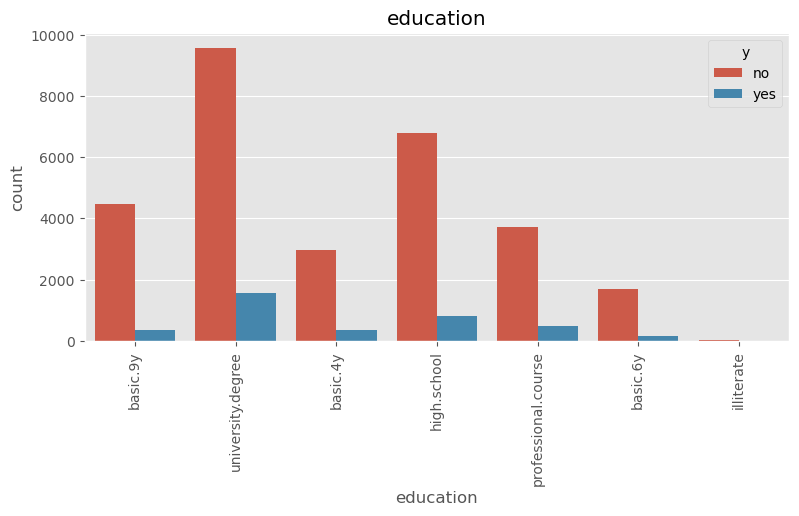

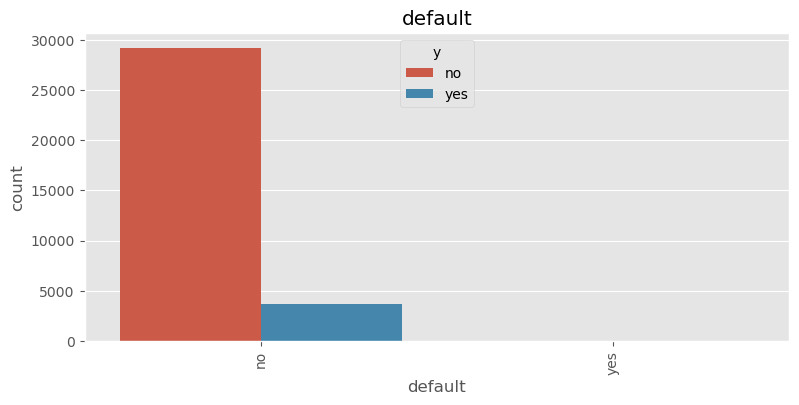

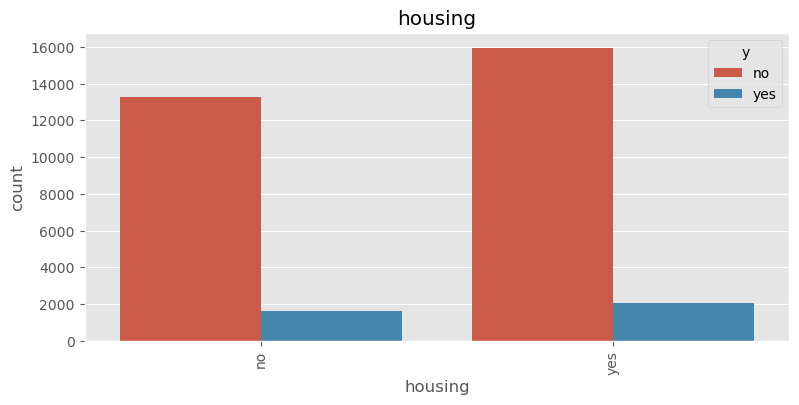

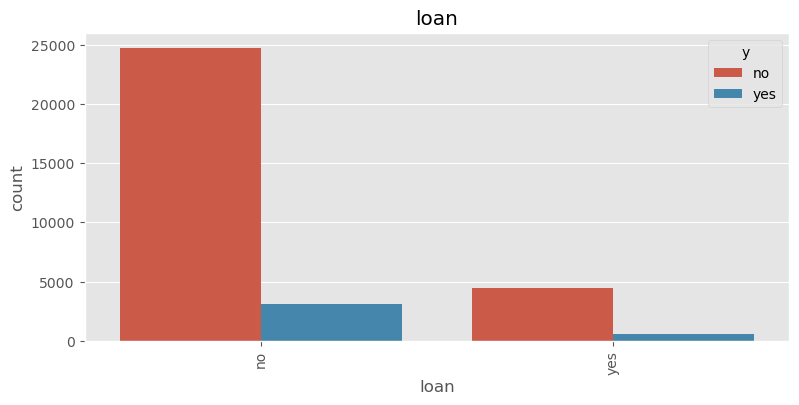

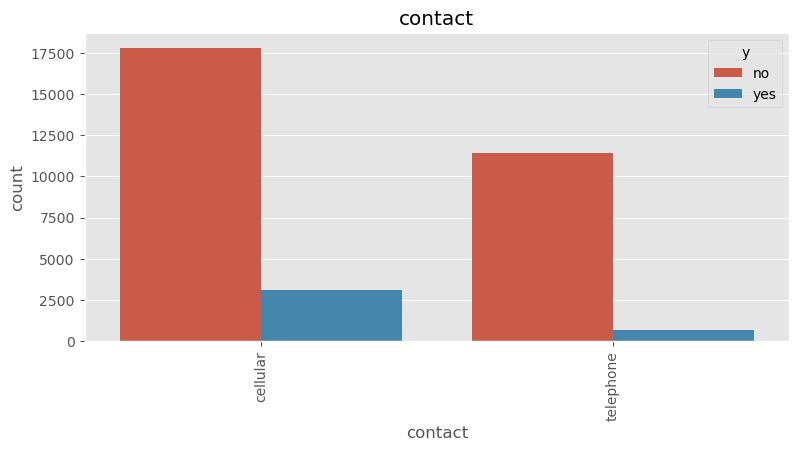

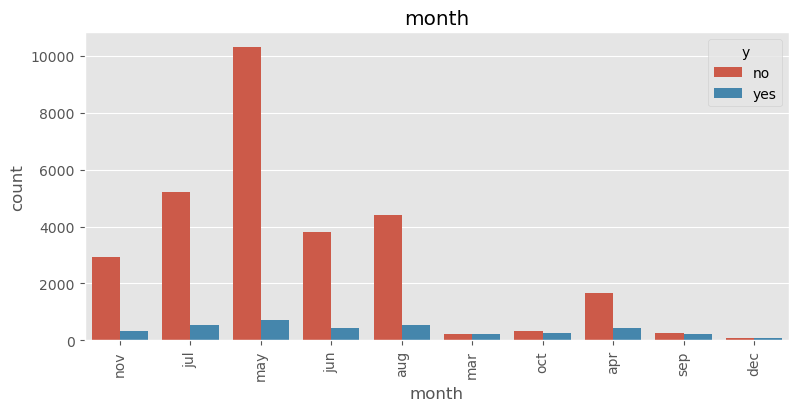

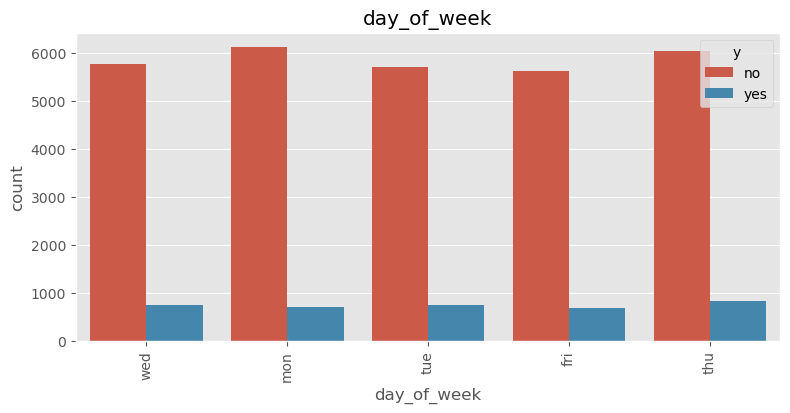

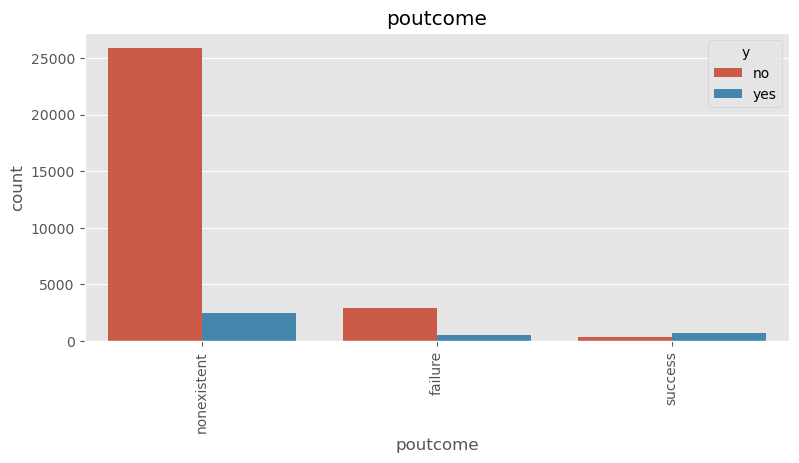

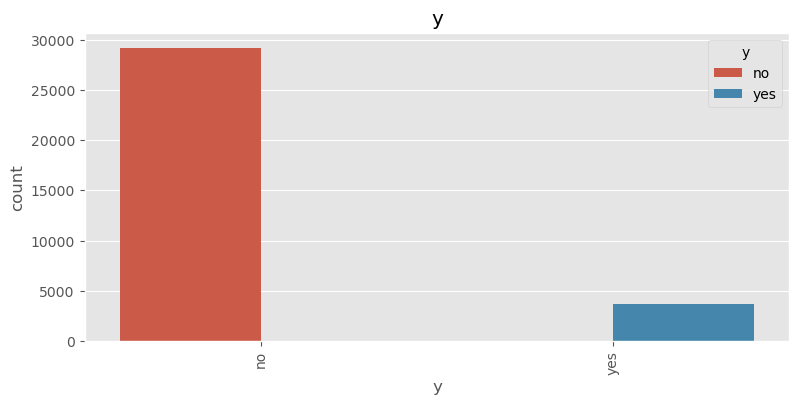

In [13]:
# Bivariate analysis with "column" and "y"
plt.style.use("ggplot")
for column in cat_var:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(df[column], hue=df["y"])
    plt.title(column)    
    plt.xticks(rotation=90)

## Observations:
Customers having administrative jobs form the majority amongst those who have subscirbed to the term deposit.
They are married
They hold a university degree
They do not hold a credit in default
Housing loan doesn't seem a priority to check for since an equal number of customers who have and have not subscribed to it seem to have subscribed to the term deposit.
Cell-phones should be the preferred mode of contact for contacting customers

## Handling Outliers
Outliers cause significant impact on the Mean and Variance. It becomes necessary to treat the outliers.

In [14]:
df.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,40.014112,258.127466,2.560607
std,10.403636,258.975917,2.752326
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,98.000000,4918.000000,56.000000


age duration and campaign are skewed towards right, we will compute the IQR and replace the outliers with the lower and upper boundaries

In [15]:
# compute interquantile range to calculate the boundaries
lower_boundries= []
upper_boundries= []
for i in ["age", "duration", "campaign"]:
    IQR= df[i].quantile(0.75) - df[i].quantile(0.25)
    lower_bound= df[i].quantile(0.25) - (1.5*IQR)
    upper_bound= df[i].quantile(0.75) + (1.5*IQR)
    
    print(i, ":", lower_bound, ",",  upper_bound)
    
    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)

age : 9.5 , 69.5
duration : -221.0 , 643.0
campaign : -2.0 , 6.0


In [16]:
lower_boundries

[9.5, -221.0, -2.0]

In [17]:
upper_boundries

[69.5, 643.0, 6.0]

In [18]:
# replace the all the outliers which is greater then upper boundary by upper boundary
j = 0
for i in ["age", "duration", "campaign"]:
    df.loc[df[i] > upper_boundries[j], i] = int(upper_boundries[j])
    j = j + 1  

Since, for age the lower boundary (9.5) < minimum value (17)
for duration and campaign the lower boundaries are negative (-221.0), (-2.0) resp.
replacing outliers with the lower boundary is not required

In [19]:
# without outliers
df.describe()

,age,duration,campaign
count,32950.000000,32950.000000,32950.000000
mean,39.929894,234.923915,2.271077
std,10.118566,176.854558,1.546302
min,17.000000,0.000000,1.000000
25%,32.000000,103.000000,1.000000
50%,38.000000,180.000000,2.000000
75%,47.000000,319.000000,3.000000
max,69.000000,643.000000,6.000000


After replacing the outliers with the upper boundary, the maximum values has been changed without impacting any other parameters like mean, standard deviation and quartiles.

## One Hot Encoding Categorical Features
Machine learning algorithm can only read numerical values. It is therefore essential to encode categorical features into numerical values

In [20]:
#categorical features
cat_var

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [21]:
# check categorical class
for i in cat_var:
    print(i, ":", df[i].unique())
    print(i, ":", df[i].nunique())
    print()

job : ['blue-collar' 'entrepreneur' 'retired' 'admin.' 'student' 'services'
 'technician' 'self-employed' 'management' 'unemployed' 'housemaid']
job : 11

marital : ['married' 'divorced' 'single']
marital : 3

education : ['basic.9y' 'university.degree' 'basic.4y' 'high.school'
 'professional.course' 'basic.6y' 'illiterate']
education : 7

default : ['no' 'yes']
default : 2

housing : ['no' 'yes']
housing : 2

loan : ['no' 'yes']
loan : 2

contact : ['cellular' 'telephone']
contact : 2

month : ['nov' 'jul' 'may' 'jun' 'aug' 'mar' 'oct' 'apr' 'sep' 'dec']
month : 10

day_of_week : ['wed' 'mon' 'tue' 'fri' 'thu']
day_of_week : 5

poutcome : ['nonexistent' 'failure' 'success']
poutcome : 3

y : ['no' 'yes']
y : 2



In [22]:
# initializing label encoder
le= LabelEncoder()

# iterating through each categorical feature and label encoding them
for feature in cat_var:
    df[feature]= le.fit_transform(df[feature])
    
# label encoded dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y
0,49,1,1,2,0,0,0,0,7,4,227,4,1,0
1,37,2,1,6,0,0,0,1,7,4,202,2,0,0
2,69,5,1,0,0,0,0,0,3,1,643,1,1,1
3,36,0,1,6,0,1,0,1,6,1,120,2,1,0
4,59,5,0,6,0,0,0,0,4,3,368,2,1,0


## Separating independent and dependent variables

In [23]:
# feature variables
X= df.iloc[:, :-1]

# target variable
y= df.iloc[:, -1]

## Checking Correlation of feature variables

<AxesSubplot:>

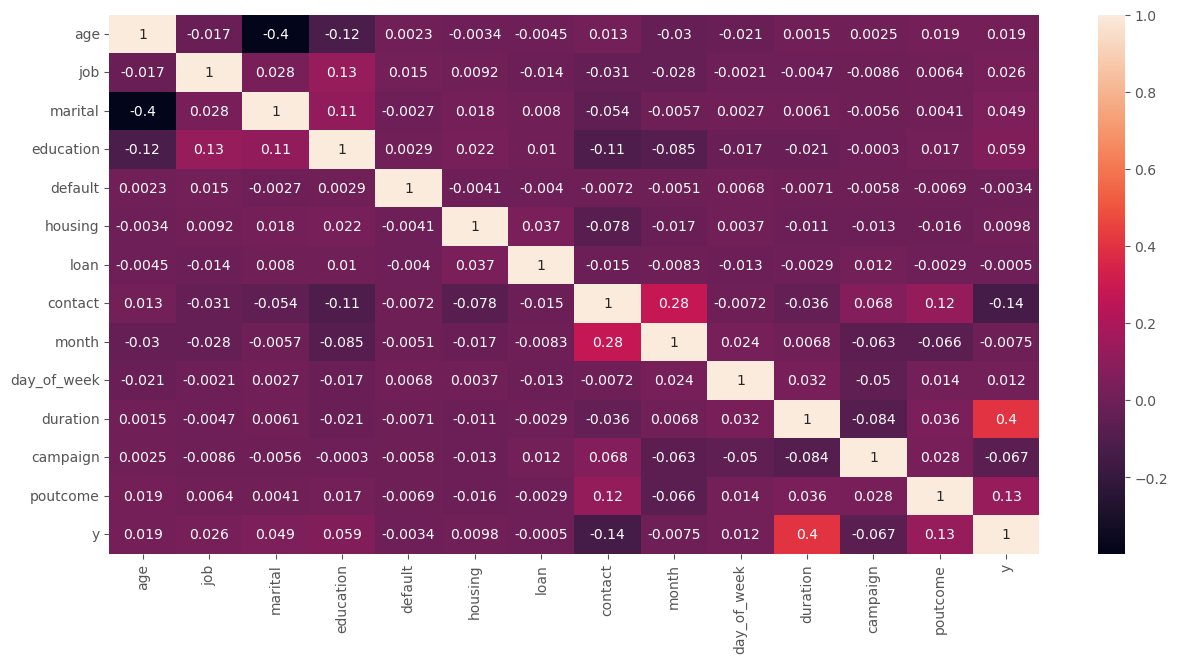

In [24]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(), annot=True)

There are no features that are highly correlated and inversely correlated. If we had, we could have written the condition that if the correlation is higher than 0.8 (or can be any threshold value depending on the domain knowledge) and less than -0.8, we could have drop those features. Because those correlated features would have been doing the same job.

## Handling imbalanced dataset
Since the class distribution in the target variable is ~89:11 indicating an imbalance dataset, we need to resample it

In [25]:
#initialising oversampling
# smt= SMOTETomek(random_state=42)
smt = SMOTETomek(random_state=42)

#implementing oversampling to training data
X_sm, y_sm= smt.fit_resample(X,y)

# x_sm and y_sm are the resampled data

# target class count of resampled dataset
y_sm.value_counts()

0    28997
1    28997
Name: y, dtype: int64

In [26]:
# Splitting resampled data in train and test data
X_train, X_test, y_train, y_test= train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [27]:
# Gridsearch and hyperparameter tuning
# selecting the classifier
##log_reg= LogisticRegression()

# selecting hyperparameter tuning
##log_param= {"C": 10.0**np.arange(-2,3), "penalty": ["l1", "l2"]}

# defining stratified Kfold cross validation
##cv_log= StratifiedKFold(n_splits=5)

# using gridsearch for respective parameters
##gridsearch_log= GridSearchCV(log_reg, log_param, cv=cv_log, scoring= "f1_macro", n_jobs=-1, verbose=2)

# fitting the model on resampled data
##gridsearch_log.fit(x_train, y_train)

# printing best score and best parameters
##print("best score is:" ,gridsearch_log.best_score_)
##print("best parameters are:" ,gridsearch_log.best_params_)

## Logistic Regression

In [28]:
# selecting the classifier
model_lg= LogisticRegression()
model_lg.fit(X_train, y_train)
y_pred_lg = model_lg.predict(X_test)
y_pred_lg

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 1, ..., 1, 0, 1])

[[4614 1080]
 [1185 4720]]
0.8047245452194155
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      5694
           1       0.81      0.80      0.81      5905

    accuracy                           0.80     11599
   macro avg       0.80      0.80      0.80     11599
weighted avg       0.80      0.80      0.80     11599



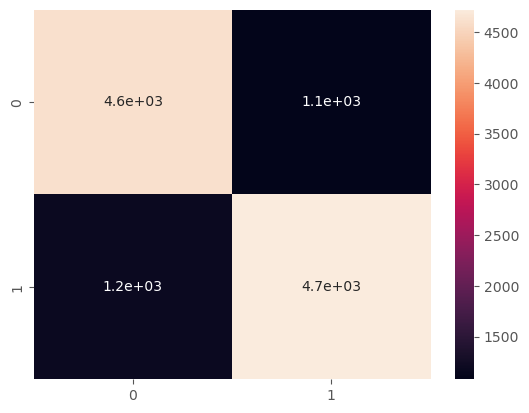

In [29]:
# Confusion Matrix & Classification Report Logistic Regression
confusion_matrix_lg = confusion_matrix(y_test, y_pred_lg)
print(confusion_matrix_lg)
sns.heatmap(confusion_matrix_lg, annot=True)
print(accuracy_score(y_test, y_pred_lg))
print(classification_report(y_test, y_pred_lg))

## Decision Tree

In [30]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
y_pred_dt

array([1, 0, 1, ..., 1, 1, 1])

[[4977  717]
 [ 498 5407]]
0.8952495904819381
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5694
           1       0.88      0.92      0.90      5905

    accuracy                           0.90     11599
   macro avg       0.90      0.89      0.90     11599
weighted avg       0.90      0.90      0.90     11599



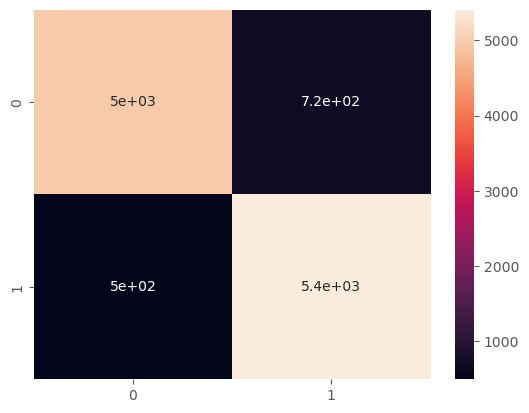

In [31]:
# Confusion Matrix & Classification Report Decision Tree
confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(confusion_matrix_dt)
sns.heatmap(confusion_matrix_dt, annot=True)
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

## SVM

In [32]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test) # predict menghasilkan series (array)
y_pred_svm

array([0, 0, 0, ..., 1, 0, 1])

[[4263 1431]
 [1650 4255]]
0.7343736529011121
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      5694
           1       0.75      0.72      0.73      5905

    accuracy                           0.73     11599
   macro avg       0.73      0.73      0.73     11599
weighted avg       0.73      0.73      0.73     11599



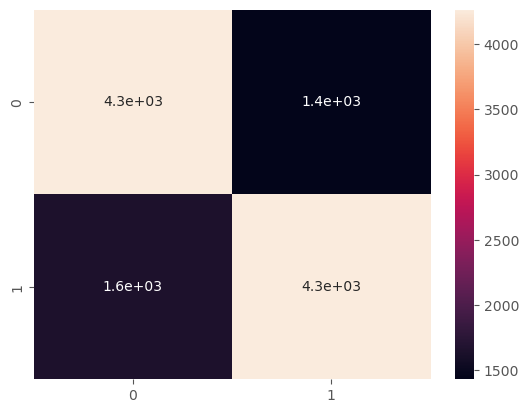

In [33]:
# Confusion Matrix & Classification Report SVM
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(confusion_matrix_svm)
sns.heatmap(confusion_matrix_svm, annot=True)
print(accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

## Random Forest (Ensemble Learning)

In [34]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test) # predict menghasilkan series (array)
y_pred_rf

array([0, 0, 0, ..., 1, 1, 1])

[[5125  569]
 [ 304 5601]]
0.9247348909388741
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      5694
           1       0.91      0.95      0.93      5905

    accuracy                           0.92     11599
   macro avg       0.93      0.92      0.92     11599
weighted avg       0.93      0.92      0.92     11599



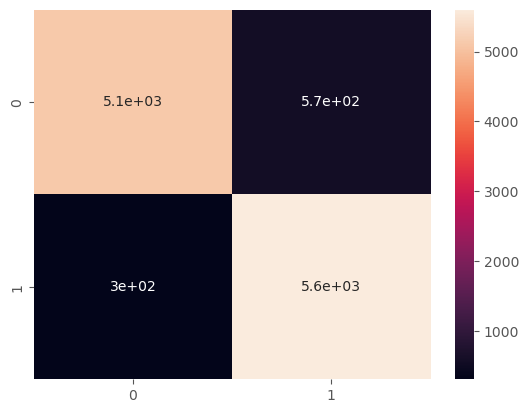

In [35]:
# Confusion Matrix & Classification Report Random Forest
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix_rf)
sns.heatmap(confusion_matrix_rf, annot=True)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

## XGBoost

In [36]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test) # predict menghasilkan series (array)
y_pred_xgb
#print(); print(model_xgb)

array([1, 0, 1, ..., 1, 1, 1])

[[5085  609]
 [ 424 5481]]
0.910940598327442
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      5694
           1       0.90      0.93      0.91      5905

    accuracy                           0.91     11599
   macro avg       0.91      0.91      0.91     11599
weighted avg       0.91      0.91      0.91     11599



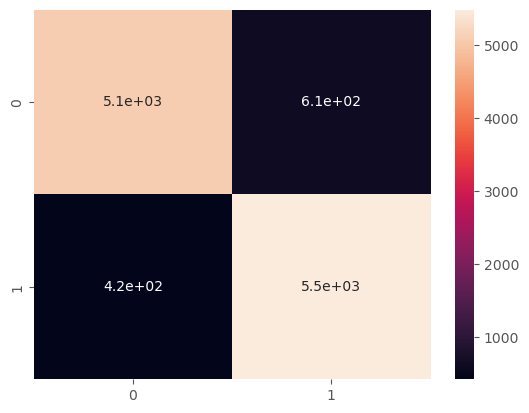

In [37]:
# Confusion Matrix & Classification Report XGBoost
confusion_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(confusion_matrix_xgb)
sns.heatmap(confusion_matrix_xgb, annot=True)
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

## Gaussian Naive-Bayes

In [38]:
model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)
y_pred_gnb = model_gnb.predict(X_test)
y_pred_gnb

array([1, 0, 1, ..., 1, 1, 1])

[[3391 2303]
 [ 646 5259]]
0.7457539443055435
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      5694
           1       0.70      0.89      0.78      5905

    accuracy                           0.75     11599
   macro avg       0.77      0.74      0.74     11599
weighted avg       0.77      0.75      0.74     11599



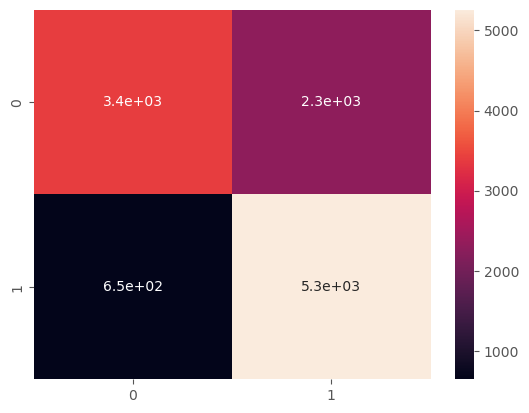

In [39]:
# Confusion Matrix & Classification Report Gaussian Naive-Bayes
confusion_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
print(confusion_matrix_gnb)
sns.heatmap(confusion_matrix_gnb, annot=True)
print(accuracy_score(y_test, y_pred_gnb))
print(classification_report(y_test, y_pred_gnb))

## Neural Network

In [40]:
# pembuatan model terdiri dari 2 hidden layer + 1 output layer
## model_nn = Sequential()
## model.add(Dense(20, input_dim=25, activation='relu')) # hidden layer pertama
## model.add(Dense(40, activation='relu')) # hidden layer kedua
## model.add(Dense(1, activation='sigmoid'))

## Prediction on the Test dataset

In [41]:
test_data= pd.read_csv("new_test.csv")
test_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome
0,32,4,0,6,0,0,0,0,3,3,131,5,1
1,37,10,3,6,0,0,0,0,4,3,100,1,1
2,55,5,0,5,1,2,0,0,3,2,131,2,1
3,44,2,1,0,1,0,0,1,4,3,48,2,1
4,28,0,2,3,0,0,0,0,5,0,144,2,1


Random Forest classifier has given the best metric score on the validation data.(93%)

In [42]:
# predicting the test data
model_rf = RandomForestClassifier()
y_predicted= model_rf.predict(test_data)
y_predicted

array([0, 0, 0, ..., 1, 0, 0])

In [43]:
# dataset of predicted values for target variable y
prediction= pd.DataFrame(y_predicted, columns=["y_predicted"])
prediction_dataset= pd.concat([test_data, prediction], axis=1)
prediction_dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,y_predicted
0,32,4,0,6,0,0,0,0,3,3,131,5,1,0
1,37,10,3,6,0,0,0,0,4,3,100,1,1,0
2,55,5,0,5,1,2,0,0,3,2,131,2,1,0
3,44,2,1,0,1,0,0,1,4,3,48,2,1,0
4,28,0,2,3,0,0,0,0,5,0,144,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8233,48,4,1,2,0,2,0,0,6,3,554,1,1,1
8234,30,7,2,3,0,2,0,0,6,0,159,1,1,0
8235,33,7,1,3,0,0,0,0,4,1,472,1,0,1
8236,44,1,1,1,0,2,2,1,6,1,554,5,1,0
